# Exploring stative and active verbs

This notebook explores quantitative methods for determining the inherent situational aspect (stative/active) of Hebrew verbs in a reduced corpus (Genesis - Kings).

In [1]:
#Dataset path
PATH = 'datasets/'

import os
import collections
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt

#Display
from IPython.display import display, clear_output
import Logos

In [2]:
from tf.app import use
A = use('bhsa', hoist=globals(), mod='etcbc/heads/tf')

	connecting to online GitHub repo annotation/app-bhsa ... connected
Using TF-app in C:\Users\Ejer/text-fabric-data/annotation/app-bhsa/code:
	rv1.2=#5fdf1778d51d938bfe80b37b415e36618e50190c (latest release)
	connecting to online GitHub repo etcbc/bhsa ... connected
Using data in C:\Users\Ejer/text-fabric-data/etcbc/bhsa/tf/c:
	rv1.6=#bac4a9f5a2bbdede96ba6caea45e762fe88f88c5 (latest release)
	connecting to online GitHub repo etcbc/phono ... connected
Using data in C:\Users\Ejer/text-fabric-data/etcbc/phono/tf/c:
	r1.2=#1ac68e976ee4a7f23eb6bb4c6f401a033d0ec169 (latest release)
	connecting to online GitHub repo etcbc/parallels ... connected
Using data in C:\Users\Ejer/text-fabric-data/etcbc/parallels/tf/c:
	r1.2=#395dfe2cb69c261862fab9f0289e594a52121d5c (latest release)
	connecting to online GitHub repo etcbc/heads ... connected
Using data in C:\Users\Ejer/text-fabric-data/etcbc/heads/tf/c:
	rv.1.3.1=#6efbd7adb3ccfd3d4dcd780f76c5f86672395eb8 (latest release)
   |     0.02s No structure in

### Basic functions

In [3]:
def simple_bar(dic, sort=True, heb=False):    
    df = pd.DataFrame([dic]).T
    if sort:
        df = df.sort_values(by=0, ascending=False)
    
    plt.bar(x=df.index, height=df.loc[:,0])
    
    if heb:
        new_xticks = [f"{reverse_hb(l[:l.index('_')])} {l[l.index('_')+1:]}" for l in list(df.index)]
        plt.xticks(df.index, new_xticks, rotation=30, ha='right', rotation_mode="anchor", size=12)
    
    plt.yticks(size=12)
    plt.show()
    
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

### Preparing corpus

In [4]:
# prepare the corpus

corpus = [book for book in F.otype.s('book') if book < T.nodeFromSection(('Isaiah',))]
print('Corpus:\n')
print('\n'.join(T.sectionFromNode(book)[0] for book in corpus))

Corpus:

Genesis
Exodus
Leviticus
Numbers
Deuteronomy
Joshua
Judges
1_Samuel
2_Samuel
1_Kings
2_Kings


In [5]:
sets={'corpus':corpus} # make set for searching

Phrases to consider:

In [6]:
phrases = 'Pred'

## Overall statistics

We will explore *Qal* verbs and their collocations with certain complements.

In [7]:
Qal = '''
corpus
 clause
  phrase function={}
    word vs=qal pdp=verb lex#HJH[
'''

unique_verbs = set()

for r in A.search(Qal.format(phrases), sets=sets, silent=True):
    unique_verbs.add(F.lex.v(r[3]))
    
print(f'Number of verbs in Qal and functioning as predicate: {len(unique_verbs)}')

Number of verbs in Qal and functioning as predicate: 616


How many Qal-verbs with only one complement and no object?

In [8]:
Qal_cmpl = '''
corpus
 clause
 /without/
   phrase function=Objc
 /-/
 /without/
  phrase function=Cmpl
  > phrase function=Cmpl
 /-/
  phrase function={}
    word vs=qal pdp=verb lex#HJH[
  phrase function=Cmpl
'''

unique_verbs_cmpl = set()

for r in A.search(Qal_cmpl.format(phrases), sets=sets, silent=True):
    unique_verbs_cmpl.add(F.lex.v(r[3]))
    
print(f'Number of verbs in Qal with complement: {len(unique_verbs_cmpl)}')

Number of verbs in Qal with complement: 333


That is, 283 verb lexemes are not accounted for by this analysis. Those lexemes may have other significant modifiers, such as time and locative phrases. 

In [9]:
len(unique_verbs)-len(unique_verbs_cmpl)

283

## Breaking down complements phrases:

In [10]:
complements = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
    phrase function=Cmpl
'''
complements = A.search(complements.format(phrases), sets=sets)

  3.42s 6403 results


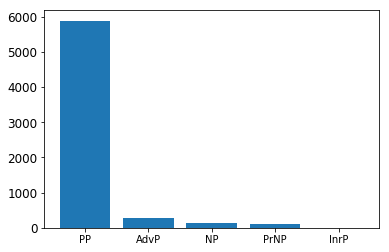

In [11]:
complement_types = collections.defaultdict(int)

for r in complements:
    complement_types[F.typ.v(r[4])] += 1
    
simple_bar(complement_types)

In [12]:
complement_types

defaultdict(int, {'PP': 5882, 'NP': 126, 'AdvP': 269, 'InrP': 7, 'PrNP': 119})

### Zooming in on Prepositional Phrases

In [13]:
PP  = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl typ=PP
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
'''

PP = A.search(PP.format(phrases), sets=sets)

  3.67s 5882 results


In [14]:
PP_sp = collections.defaultdict(int)

for r in PP:
    head = E.head.t(r[2])[0]
    PP_sp[F.sp.v(head)] += 1

PP_sp

defaultdict(int, {'prep': 5657, 'subs': 225})

Prepositions:

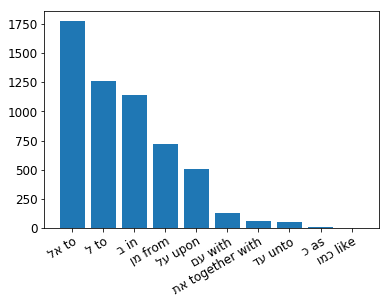

In [15]:
prep_dict = collections.defaultdict(int)

for r in PP:
    head = E.head.t(r[2])[0]
    if F.sp.v(head) == 'prep':
        prep_dict[f'{F.lex_utf8.v(head)}_{F.gloss.v(L.u(head, "lex")[0])}'] += 1
                  
simple_bar(prep_dict, heb=True)

### Exploring prepositions

We will explore the prepositions in some depth, because the prepositions are polysemous and can be used in many different functions. We select the complement types that are most likely to be directional or locational. Secondly, these complement phrases are manually checked to discard other uses of the complement phrase.

The following query is the default query to explore the prepositions one by one:

In [16]:
query = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl
      =: word lex={}
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
'''

### ל

ל is used in a great variety of ways. One of the basic senses is locative (cf. BHRG §11.2.10b), but the preposition may mark either position or direction, depending on the verb, making, in effect, the preposition very versatile. For that reason, the preposition is not a good indicator as to whether the verb is stative or active.

In [17]:
L_prep = A.search(query.format('L',phrases), sets=sets)
A.show(L_prep, end=1)

  5.48s 1258 results


### אל

אל is used for a varity of expressions, typically denoting either direction or dative, e.g. recipient or addressee, but also ethical dative and comitative (cf. BHRG §11.2.2a). We will take a look at those nouns governed by the preposition to sort isolate directional and locational senses:

In [18]:
EL_prep = A.search(query.format('>L',phrases), sets=sets)
A.show(EL_prep, end=1)

  5.39s 1769 results


###  ב

The prepositions ב is used both as locative ("in", "by", "at"), but also as instrument ("with"). To distinguish these senses, we take a closer look at the nouns governed by the preposition:

In [23]:
B_prep = A.search(query.format('B', phrases), sets=sets)
A.show(B_prep, start=1000, end=1005)

  4.53s 1131 results


### מן

מן has both a spatial, a partial, and a comparative sense. Even the spatial sense is not easy to distinguish because it can refer to the origin of a movement or the direction where a thing is located (cf. BHRG, §11.2.11b). Therefore, we skip this preposition in the present analysis.

In [20]:
MN_prep = A.search(query.format('MN', phrases), sets=sets)

  3.81s 720 results


### על

The most commen sense of על is the spatial "on" or "over" (cf. BHRG §11.2.13b). Apart from this locative sense, על may less frequently be used as the goal of a movement. The preposition can also be used as denoting opposition ("against") or as marking a topic ("concerning"). As before, we will take a look at the nouns governed by the preposition: 

In [21]:
AL_prep = A.search(query.format('<L', phrases), sets=sets)

  3.83s 505 results


### Final ה

The final-H construction is generally considered a construction of direction, e.g.: "... in coming to Gerah" or "... in direction of Gerah" (Gen 10:19):

In [22]:
final_h = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl
      word uvf=H
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
'''

final_h = A.search(final_h.format(phrases), sets=sets)
A.show(final_h, start=30, end=35)

  3.71s 234 results


### Summing up

Moreover, we have chosen only to work with constructions occuring at least five times for each preposition. This restriction, along with the stoplist, reduces the relevant cases significantly:

In [59]:
constructions = [L_prep, EL_prep, B_prep, MN_prep, AL_prep, final_h]

cases = sum([len(c) for c in constructions])
cases

5617

The number of verbs considered:

In [60]:
verbs = set()

for c in constructions:
    for r in c:
        verbs.add(F.lex.v(r[5]))
        
len(verbs)

317

### Export

Finally, we export the resulting dataset for manual inspection of all cases:

In [61]:
clause_dict = collections.defaultdict()

for c in constructions:
    for r in c:
        clause = r[1]
        verb = F.lex.v(r[5])
        cmpl = r[2]
        
        if F.uvf.v(r[3]) == 'H':
            cmpl_type = 'final_h'
        else:
            cmpl_type = F.lex.v(r[3])

        clause_dict[clause] = [clause, verb, cmpl, cmpl_type]
        
data = pd.DataFrame(clause_dict).T
data.columns = ['clause','verb','phrase','cmpl_type']

data.head()

,clause,verb,phrase,cmpl_type
427656,427656,>MR[,651855,L
427808,427808,>MR[,652310,L
427826,427826,>MR[,652355,L
427844,427844,>MR[,652408,L
427845,427845,CM<[,652412,L


In [62]:
data.to_csv(f'{PATH}corpus_analysis_loc_dir.csv')

## Annotating dataset

The dataset created above is to be manually corrected for erroneous cases of the complements. We may expect a large number of cases to be deleted because the prepositions can be used in a great variety of functions. The two following complement functions are accepted and will be applied to the dataset:

* Locational complement: If the complement describes the place at/on/nearby which an event takes place or where an entity is situated
* Directional complement: If the complement describes the geographical target of an event

Ambigious cases will be marked with a question-marked while erroneous cases will be marked with '-'.

In [25]:
data = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_4.csv')
data = data[['clause','verb','phrase','cmpl_type','cmpl_func']]

#Create new column that combines complement type and function:
data.insert(5, "label", data.cmpl_type + '_' + data.cmpl_func)

In [26]:
data.head()

,clause,verb,phrase,cmpl_type,cmpl_func,label
0,427771,>MR[,652201,>L,-,>L_-
1,427774,>MR[,652212,>L,-,>L_-
2,427782,>MR[,652233,>L,-,>L_-
3,427807,QR>[,652307,>L,-,>L_-
4,427831,>MR[,652368,>L,-,>L_-


Types of labels

In [27]:
set(data.label)

{'<L_-',
 '<L_?',
 '<L_DIR',
 '<L_LOC',
 '>L_-',
 '>L_?',
 '>L_DIR',
 '>L_LOC',
 'B_-',
 'B_?',
 'B_DIR',
 'B_LOC',
 'final_h_-',
 'final_h_DIR',
 'final_h_LOC'}

Labels to review:

In [28]:
review_labels = ['<L_-','>L_-','B_-','final_h_-','<L_?','>L_?','B_?',]

In [29]:
verb_counter = collections.Counter(list(data.verb))

verbs = [v for v in verb_counter if verb_counter[v] >= 5]

data1 = data[(data.verb.isin(verbs)) & (data.label.isin(review_labels)) & (data.verb != '>MR[')]
len(data1)

1424

In [46]:
data1.head()

,clause,verb,phrase,cmpl_type,cmpl_func,label
3,427807,QR>[,652307,>L,-,>L_-
11,427906,QWM[,652602,>L,-,>L_-
43,428847,CM<[,655556,>L,-,>L_-
49,428976,NTN[,655972,>L,-,>L_-
58,429128,QR>[,656396,>L,-,>L_-


A function is created to generate an interface for viewing the case and evaluating the function of the complement:

In [21]:
annotations = 'LOC DIR ? -'.split()

STOP = 'stop'
error_message = "Input is invalid"

In [47]:
def input_loop(question, right_answer):
    '''
    input_loop is used when the user is required to make an input. Question has to be a string,
    while right_answer is a list of accepted answer(s).
    '''
    while True:
        test = input(f'{question} ({",".join(right_answer)})') #The user is required to respond to message.
        if test in right_answer:
            return test
        elif test in [STOP]: #Input is accepted
            return test
        else: #Input is wrong and the user has respond again.
            print(error_message)

def annotate(clauses, df, index='index'):
    answers = {}
    
    for cl in clauses:
        
        for ph in Locality.d(cl, 'phrase'):
            if F.function.v(ph) in {'Pred','PreS','PreO','PreC','PtcO'}:
                pred = ph
        
        clear_output()
        
        Logos.Logos().link(T.sectionFromNode(cl))
        row = df[df.clause==cl]
        A.pretty(row.clause.item(), highlights={row.phrase.item():'gold', pred:'lightgreen'})
        
        question = f'Function?'

        cmpl_func = input_loop(question, annotations)

        if cmpl_func == STOP:
            return answers
        else:
            answers[cl] = cl, row.verb.item(), row.phrase.item(), row.cmpl_type.item(), cmpl_func
    return answers

In [50]:
annotated_datasets = []
prev_runs = [run1]

def Clauses(orig_data, prev_runs, annotated_datasets):

    total_clauses = list(orig_data.clause)
    
    annotated_clauses = []
    remaining_clauses = []
    
    ##2. Check already annotated datasets:
    for csv in annotated_datasets:
        data = pd.read_csv(csv)
        clauses = list(data.clause)
        
        for cl in clauses:
            annotated_clauses.append(cl)
         
    ##1. Check previous runs (dictionaries with annotations)
    for r in prev_runs:
        for cl in r:
            annotated_clauses.append(cl)
            
    ##2. Determine the remaining clauses
    for cl in total_clauses:
        if not cl in annotated_clauses:
            remaining_clauses.append(cl)
    
    return remaining_clauses
        
clauses = Clauses(data1,prev_runs,annotated_datasets)

In [51]:
len(clauses)

1340

In [52]:
run2 = annotate(clauses, data1)

Function? (LOC,DIR,?,-)stop


#### Merge outputs

In [54]:
outputs = [run1,run2]

In [53]:
def Merge(outputs, colnames=data.columns):
    new_dict = {}
    for r in outputs:
        for lex in r:
            new_dict[lex] = r[lex]

    df = pd.DataFrame(new_dict).T
    df.columns = colnames
    return df

In [62]:
df = Merge(outputs, data1.columns[:-1])

In [63]:
standard_path = f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_corrections'

VERSION = 1

path = False
while not path:
    
    if os.path.isfile(f'{standard_path}{VERSION}.csv'):
        
        VERSION += 1
        
    else:
        path = f'{standard_path}{VERSION}.csv'
        
df.to_csv(path)

### Merge datasets

In [27]:
datasets = [f'{PATH}corpus_analysis_loc_dir_annotated1.csv',f'{PATH}corpus_analysis_loc_dir_annotated2.csv',
            f'{PATH}corpus_analysis_loc_dir_annotated3.csv',f'{PATH}corpus_analysis_loc_dir_annotated4.csv',
            f'{PATH}corpus_analysis_loc_dir_annotated5.csv',f'{PATH}corpus_analysis_loc_dir_annotated6.csv',
            f'{PATH}corpus_analysis_loc_dir_annotated_BETA1.csv',
            f'{PATH}corpus_analysis_loc_dir_annotated_BETA2.csv',
            f'{PATH}corpus_analysis_loc_dir_annotated_BETA3.csv']

new_df = pd.DataFrame()

for csv in datasets:
    df = pd.read_csv(csv)
    new_df = new_df.append(df)
    
len(new_df)

5043

In [34]:
#Filter dataset to exclude clauses with more than one complement phrase:

final_df = new_df[new_df.clause.isin(orig_clauses)]

In [35]:
final_df.head()

,Unnamed: 0,clause,verb,phrase,cmpl_type,cmpl_func
0,427771,427771,>MR[,652201,>L,-
1,427774,427774,>MR[,652212,>L,-
2,427782,427782,>MR[,652233,>L,-
3,427807,427807,QR>[,652307,>L,-
4,427831,427831,>MR[,652368,>L,-


In [36]:
final_df.to_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL.csv')

## Review

The dataset needs to be corrected for ambigious cases (marked with '?') and checked for inconsistencies. The inconsistencies are reviewed by cross-validiting whether any verb has differently annotated complements. Different annotations may be perfectly valid, but they can also be the result of inconsistent annotations.

### #1 Correcting verb inconsistencies

We first check for inconsistencies by cross-tabulating verbs and the annotated complement functions. If the verb has been annotated with both locational and directional complements, we explore the verb in depth.

In [151]:
def get_head(ph):
    nom_head = E.nhead.t(ph)
    if len(nom_head) > 0:
        return nom_head[0]
    else:
        return E.head.t(ph)[0]

In [167]:
data = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL.csv')

#Insert column with complement heads (noun or preposition):
cmpl_heads = [F.lex.v(get_head(ph)) for ph in data.phrase]
data.insert(7, 'nhead', cmpl_heads)

#Insert label consisting of verb + complement type
data.insert(8, 'label', data.verb + '_' + data.cmpl_type)
data.head()

,Unnamed: 0,Unnamed: 0.1,clause,verb,phrase,cmpl_type,cmpl_func,nhead,label
0,0,427771,427771,>MR[,652201,>L,-,>CH/,>MR[_>L
1,1,427774,427774,>MR[,652212,>L,-,NXC/,>MR[_>L
2,2,427782,427782,>MR[,652233,>L,-,>CH/,>MR[_>L
3,3,427807,427807,QR>[,652307,>L,-,>DM/,QR>[_>L
4,4,427831,427831,>MR[,652368,>L,-,NXC/,>MR[_>L


In [71]:
cross_val = pd.crosstab(index=[data.verb, data.cmpl_type], columns=[data.cmpl_func])
cross_val.head(10)

cmpl_func        -  ?  DIR  LOC
verb cmpl_type                 
<BD[ B          11  0    0    0
<BR[ <L          5  3    1    1
     >L          0  0   16    0
     B           2  0    4   24
     final_h     0  0   12    0
<CN[ B           1  0    0    0
<FH[ <L          4  0   10    1
     B           9  0    0   10
     final_h     2  0    0    0
<JV[ >L          0  0    2    0

We want to perfom a review of verbs which diverge in function for a respective form, that is, if a complement type has been annotated with different functions for a single verb, all instances of that combination of verb and complement are isolated for further analysis. That also means that even if we see diversity in the tagging of a verb, all cases of the verb is not necessarily extracted, but only the specific combinations where the verb diverges. This procedure should decrease the work load while still allowing for close inspection of "suspicious cases".

In [5]:
review_verbs = []

for r in cross_val.iterrows():
    verb = r[0][0]
    cmpl_type = r[0][1]
    
    if r[1]['DIR'] > 0 and r[1]['LOC'] > 0:
        review_verbs.append(f'{verb}_{cmpl_type}')

review_verbs

['<BR[_<L',
 '<BR[_B',
 '<FH[_<L',
 '<LH[_B',
 '<MD[_>L',
 '<ZB[_B',
 'BW>[_B',
 'CLX[_B',
 'CPK[_>L',
 'FJM[_>L',
 'FJM[_B',
 'HLK[_<L',
 'HLK[_B',
 'JCB[_<L',
 'KR<[_<L',
 'NF>[_<L',
 'NF>[_B',
 'NPL[_<L',
 'NPL[_B',
 'NTN[_<L',
 'NTN[_B',
 'NVC[_<L',
 'NWX[_<L',
 'TQ<[_B',
 'VBL[_B',
 'XGR[_B']

In [6]:
review_data = data[data.label.isin(review_verbs)]

#Sort according to lexeme:
review_data = review_data.sort_values(by='verb')

len(review_data)

736

In [7]:
review_data.head()

,Unnamed: 0,Unnamed: 0.1,clause,verb,phrase,cmpl_type,cmpl_func,label
3079,31,454788,454788,<BR[,734174,B,LOC,<BR[_B
4140,353,455386,455386,<BR[,735992,<L,?,<BR[_<L
2566,18,445161,445161,<BR[,705049,B,LOC,<BR[_B
2035,458,430810,430810,<BR[,661438,B,DIR,<BR[_B
2720,201,448072,448072,<BR[,713888,B,LOC,<BR[_B


In [41]:
prev_runs = [run1, run2, run3, run4, run5, run6, run7, run8, run9]

review_clauses = Clauses(review_data, prev_runs, annotated_datasets)
len(review_clauses)

0

In [36]:
run10 = annotate(review_clauses, index='clause')

Function? (LOC,DIR,?,-)LOC


Having annotated the clauses a second time, the outputs are merged to a single dataframe and exported.

In [45]:
df = Merge(prev_runs, colnames=['clause', 'verb', 'phrase', 'cmpl_type', 'cmpl_func'])
df.head()

,clause,verb,phrase,cmpl_type,cmpl_func
454788,454788,<BR[,734174,B,LOC
455386,455386,<BR[,735992,<L,?
445161,445161,<BR[,705049,B,LOC
430810,430810,<BR[,661438,B,LOC
448072,448072,<BR[,713888,B,LOC


In [46]:
df.to_csv(f'{PATH}corpus_analysis_loc_dir_annotated_REVIEW_1.csv')

#### Implementing corrections

We implement the corrections by inserting the results of the review into the first completed dataset.

In [130]:
review_data = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_REVIEW_1.csv')

In [48]:
def implementCorrections(orig_data, review_data):
    
    n=0
    update_anno = []

    for r in orig_data.iterrows():

        cl = r[1].clause
        orig_anno = r[1].cmpl_func

        if cl in list(review_data.clause):
            
            
            review_anno = review_data[review_data.clause == cl].cmpl_func.item()
            
            if review_anno != orig_anno:
                n+=1
                update_anno.append(review_anno)
                
            else:
                
                update_anno.append(orig_anno)
                
        else:
            update_anno.append(orig_anno)
            
    orig_data.cmpl_func = update_anno
                
    return f'Changes made: {n}', orig_data

In [169]:
update_df = implementCorrections(data, review_data)
update_df[0]

'Changes made: 170'

In [170]:
update_df[1].head()

,Unnamed: 0,Unnamed: 0.1,clause,verb,phrase,cmpl_type,cmpl_func,nhead,label
0,0,427771,427771,>MR[,652201,>L,-,>CH/,>MR[_>L
1,1,427774,427774,>MR[,652212,>L,-,NXC/,>MR[_>L
2,2,427782,427782,>MR[,652233,>L,-,>CH/,>MR[_>L
3,3,427807,427807,QR>[,652307,>L,-,>DM/,QR>[_>L
4,4,427831,427831,>MR[,652368,>L,-,NXC/,>MR[_>L


### #2 Reviewing inconsistencies of similar verb + complement

The next check regards whether similar constructions of verb and complement are annotated similarly. This cross-check involves looking at the lexemes of the verb and the head of the complement phrase, respectively.

In [171]:
review_data2 = update_df[1]

In [196]:
cross_val = pd.crosstab(index=[review_data2.verb, review_data2.nhead], columns=[review_data2.cmpl_func])
cross_val.head(25)

cmpl_func      -  ?  DIR  LOC
verb nhead                   
<BD[ <LH/      1  0    0    0
     B         4  0    0    0
     BKR/      1  0    0    0
     BT/       1  0    0    0
     LBB/      1  0    0    0
     RXL=/     3  0    0    0
<BR[ <BD/      0  0    0    1
     <L        4  0    0    1
     <YMWN/    0  0    2    0
     >BL/      0  0    1    0
     >KJC/     0  0    1    0
     >L        0  0    3    0
     >RY/      0  0    4   11
     B         0  0    0    4
     BN/       0  0    2    0
     CKM=/     0  1    0    0
     CM        0  0    1    0
     CWNM/     0  0    1    0
     DRK/      0  0    0    1
     FDH/      0  0    0    1
     GBWL/     0  0    0    3
     GLGL===/  0  0    1    0
     HR/       0  0    0    1
     JM/       0  0    1    0
     JRDN/     0  0    1    0

In [189]:
review_clauses = []

for r in cross_val.iterrows():
    verb = r[0][0]
    nhead = r[0][1]
    
    if r[1]['DIR'] > 0 and r[1]['LOC'] > 0:
        clauses = list(review_data2[(review_data2.verb == verb) & (review_data2.nhead == nhead)].clause)
        review_clauses += clauses    

len(review_clauses)

91

In [198]:
run1 = annotate(review_clauses, df=review_data2, index='clause')

Function? (LOC,DIR,?,-)-


In [203]:
df = pd.DataFrame(run1).T
df.columns = ['clause', 'verb', 'phrase', 'cmpl_type', 'cmpl_func']

In [205]:
df.to_csv(f'{PATH}corpus_analysis_loc_dir_annotated_REVIEW_2.csv')

#### Implement corrections

In [206]:
review_data2 = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_REVIEW_2.csv')

In [207]:
update_df1 = implementCorrections(data, review_data2)

In [208]:
update_df1[0]

'Changes made: 6'

In [211]:
update_df1[1].to_csv((f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_2.csv'))

### #3 Reviewing question-marked cases

In [63]:
review_data3 = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_2.csv')
review_data3.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clause,verb,phrase,cmpl_type,cmpl_func,nhead,label
0,0,0,427771,427771,>MR[,652201,>L,-,>CH/,>MR[_>L
1,1,1,427774,427774,>MR[,652212,>L,-,NXC/,>MR[_>L
2,2,2,427782,427782,>MR[,652233,>L,-,>CH/,>MR[_>L
3,3,3,427807,427807,QR>[,652307,>L,-,>DM/,QR>[_>L
4,4,4,427831,427831,>MR[,652368,>L,-,NXC/,>MR[_>L


In [216]:
clauses = list(review_data3[review_data3.cmpl_func == '?'].clause)
print(f'Number of cases to review: {len(clauses)}')

Number of cases to review: 76


In [454]:
anno_upd = {}

In [64]:
def show(cl, df=review_data3):
    cmpl = int(review_data3[review_data3.clause == cl].phrase)
    Logos.Logos().link(T.sectionFromNode(cl))
    print(f'{cl}\nOriginal annotation: {review_data3[review_data3.clause == cl].cmpl_func.item()}')
    A.pretty(cl, highlights={cmpl:'gold'})

#### "Figure" is not a physical entity

In Gen 39:7 the "Figure" (in this case, the syntactic object) is not a physical object that can be moved. Therefore, there is no motion taking place.

In [456]:
show(clauses[1])

anno_upd[431982] = '-'

431982
Original annotation: ?


In Josh 19:11 (and similar cases), "border" is not a physical entity that can move.

In [457]:
show(clauses[8])

anno_upd[450511] = '-'
anno_upd[444669] = '-'

450511
Original annotation: ?


In [458]:
show(clauses[11])

anno_upd[457211] = '-'

457211
Original annotation: ?


In [459]:
show(clauses[15])

anno_upd[431311] = '-'
anno_upd[433332] = '-'

431311
Original annotation: ?


"Blood" means "guilt of blood" and is not a physical entity:

In [460]:
show(clauses[27])

anno_upd[447237] = '-'

447237
Original annotation: ?


#### "Ground" is neither goal nor space:

In Ex 28:28, the verb "to bind" takes an object that is bound to another object. It is not a movement as such and the complement is not the endgoal.

In [461]:
show(clauses[2])

anno_upd[436511] = '-'
anno_upd[437716] = '-'
anno_upd[448906] = '-'
anno_upd[454553] = '-'

436511
Original annotation: ?


In Num 4:15, the verb "touch" does not indicate a movement toward a direction, but the complement rather designates the oblique object, that is, the thing that is being touched.

In [462]:
show(clauses[4])

anno_upd[441268] = '-'

441268
Original annotation: ?


In Deut 20:19 (and similar cases) the complement seems to denote an oblique object, the entity that is being "besieged":

In [463]:
show(clauses[7])

anno_upd[447088] = '-'
anno_upd[456901] = '-'
anno_upd[458965] = '-'

447088
Original annotation: ?


A similar example is found in "enclose", that is, "protect":

In [464]:
show(clauses[13])

anno_upd[467501] = '-'

467501
Original annotation: ?


"In your heart" denotes a mental space and not a physical space:

In [465]:
show(clauses[26])

anno_upd[445788] = '-'

445788
Original annotation: ?


"In your nose" is a perhaps metaphor for "to/before you":

In [466]:
show(clauses[30])

anno_upd[448618] = '-'

448618
Original annotation: ?


The complement in Judg 11:2 seems to denote some kind of object, perhaps partitive:

In [467]:
show(clauses[34])

anno_upd[452490] = '-'

452490
Original annotation: ?


If "way" is interpreted to mean "journey" and not a concrete road, then it is not locational nor directional:

In [468]:
show(clauses[36])

anno_upd[453336] = '-'
anno_upd[455702] = '-'

453336
Original annotation: ?


"into your hands" often means to "allow someone to defeat another one", therefore not denoting a movement:

In [469]:
show(clauses[37])

anno_upd[453362] = '-'

453362
Original annotation: ?


In 1 Sam 14:43 the complement is probably Instrument:

In [470]:
show(clauses[43])

anno_upd[455585] = '-'

455585
Original annotation: ?


Sometimes "come to them" denotes marriage so it is not (primarily) a physical movement:

In [471]:
show(clauses[50])

anno_upd[462680] = '-'
anno_upd[462681] = '-'

462680
Original annotation: ?


"Write in a scroll" denotes what is being written and not the place where the scroll is written:

In [472]:
show(clauses[60])

anno_upd[446819] = '-'

446819
Original annotation: ?


"Iron yoke" is a metaphor for heavy labor:

In [473]:
show(clauses[61])

anno_upd[447939] = '-'

447939
Original annotation: ?


"On my wings" seems to be instrumental:

In [474]:
show(clauses[62])

anno_upd[448424] = '-'

448424
Original annotation: ?


"The sun shining upon the water" does not denote the place where the sun is shining but where the light reaches:

In [475]:
show(clauses[70])

anno_upd[465096] = '-'

465096
Original annotation: ?


#### Annotation changed: Locational

"Plunder among them" seems to be locational although it could also be an oblique object:

In [476]:
show(clauses[42])

anno_upd[455544] = 'LOC'

455544
Original annotation: ?


"There you shall bury me". The complement probably specifies the place for the entire event and not merely the direction.

In [526]:
show(clauses[75])

anno_upd[433457] = 'LOC'

433457
Original annotation: ?


#### Annotation changed: Directional

In [477]:
show(clauses[0])

anno_upd[430841] = 'DIR'

430841
Original annotation: ?


In [478]:
show(clauses[5])

anno_upd[441444] = 'DIR'

441444
Original annotation: ?


In [479]:
show(clauses[6])

anno_upd[443797] = 'DIR'

443797
Original annotation: ?


In [480]:
show(clauses[12])

anno_upd[458848] = 'DIR'

458848
Original annotation: ?


"Take in ones hand" implies a direction towards "hand": 

In [481]:
show(clauses[14])

anno_upd[429511] = 'DIR'
anno_upd[433923] = 'DIR'
anno_upd[433943] = 'DIR'
anno_upd[434243] = 'DIR'
anno_upd[435200] = 'DIR'
anno_upd[435430] = 'DIR'

429511
Original annotation: ?


Is "fire" a burning stick or does the phrase simply mean "lit" and therefore not exactly a transfer? We may assume from the context that it is a piece of coal or a burning stick that is put onto the sacrifice.

In [482]:
show(clauses[22])

anno_upd[438684] = 'DIR'
anno_upd[442669] = 'DIR'
anno_upd[442717] = 'DIR'

438684
Original annotation: ?


"Seek refuge" (Deut 32:37; 2 Sam 22:3) seems to imply a direction:

In [483]:
show(clauses[29])

anno_upd[448519] = 'DIR'
anno_upd[460750] = 'DIR'

448519
Original annotation: ?


In [484]:
show(clauses[38])

anno_upd[453772] = 'DIR'

453772
Original annotation: ?


In [485]:
show(clauses[55])

anno_upd[437772] = 'DIR'

437772
Original annotation: ?


In [486]:
show(clauses[67])

anno_upd[455386] = 'DIR'

455386
Original annotation: ?


#### Ambigious cases

Some cases are still ambigious, for instance "bread" in 1 Sam 20:24. It appears to denote an event rather than a physical entity. The same is true of "captivity", "round dance", "sacrifice" and "war":

In [535]:
show(clauses[9])
#show(clauses[28])
#show(clauses[39])
#show(clauses[45])
#show(clauses[46])

456579
Original annotation: ?


What does it mean to "sit in her purification blood"? Probably not a physical place but rather a situation.

In [488]:
show(clauses[23])

438944
Original annotation: ?


"Devoured in/into the end of the camp"

In [489]:
show(clauses[24])

442024
Original annotation: ?


The verb in Josh 8:13 is text-critically disputed:

In [490]:
show(clauses[32])

449497
Original annotation: ?


Also Judg 9:26; 1 Sam 14:25; Ex 30:32; Lev 13:45; 2 Sam 17:12:

In [491]:
#show(clauses[33])
#show(clauses[41])
#show(clauses[54])
#show(clauses[56])
#show(clauses[69])

Does "The messenger of the Lord ascended in the flame" indicate a direction, a location or possibly an instrument?

In [492]:
#show(clauses[35])

In [493]:
#show(clauses[47])

In [494]:
#show(clauses[49])

In [495]:
#show(clauses[53])

It is not entirely obvious what the object ("Figure") refers to so annotation is ambigious:

In [496]:
show(clauses[57])

439601
Original annotation: ?


The meaning of "quiver over" is ambigious but may denote dominion:

In [497]:
show(clauses[63])
#show(clauses[64])
#show(clauses[65])

452203
Original annotation: ?


It is not entirely clear what it means that the subject "goes down/descend on the mountain":

In [498]:
show(clauses[66])

452640
Original annotation: ?


In [499]:
#show(clauses[71])

In [500]:
#show(clauses[72])

In [521]:
#show(clauses[73])

In [523]:
#show(clauses[74])

#### Implementing corrections

In [528]:
print(f'Number of corrections made: {len(anno_upd)}')

Number of corrections made: 49


In [529]:
for cl in anno_upd:
    
    index = review_data3[review_data3.clause == cl].index.item()
    column = 'cmpl_func'
    
    review_data3.at[index, column] = anno_upd[cl]

In [530]:
len(review_data3[review_data3.cmpl_func == '?'])

27

In [539]:
review_data3.to_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_3.csv', index=False)

### #4 Review specific cases

In this final step we will walk through cases that have been marked as either erroneous or problematic during the annotation.

We do it by identifying the involved verbs and/or complement head nouns and walking through each instance. 

Questions to address:

* "bury"? Probably an event that takes place at a certain place, that is, the complement does not describe the end goal but the place.
* "gather"?
* "Turn to" (metaphorically) in 1 Kings 8:28. It probably makes sense to interpret the expressions as literally as possible for two reasons: 1) It requires more interpretation and more sources of errors, if the interpretion needs to start with an estimation of how metaphorical a statement is. 2) We may assume that a metaphor employs a familiar construction (a verb and a complement) to express a metaphorical meaning.
* Can a border ascend? (Josh 19)
* Is "touch" directional? Probably similar to blow, hit, dip, etc.
* MCL "rule" - is it locational or another sense?
* Is "to the war" directional or does "war" means the event?

In [10]:
review_verbs = ['QBR[', '>SP[', 'LQX[', 'PNH[', 'MCL[', 'MLK[', '<ZB[', 'NG<[']
review_cmpl = ['GBWL/', 'MLXMH/','JD/']

In [13]:
review_data4 = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_3.csv')
review_data4 = review_data4.sort_values(by='verb')
review_data4.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clause,verb,phrase,cmpl_type,cmpl_func,nhead,label
3098,3098,53,455257,455257,<BD[,735584,B,-,LBB/,<BD[_B
2134,2134,0,433576,433576,<BD[,669628,B,-,B,<BD[_B
2846,2846,359,450837,450837,<BD[,722083,B,-,<LH/,<BD[_B
2386,2386,319,440628,440628,<BD[,691298,B,-,B,<BD[_B
2046,2046,469,431024,431024,<BD[,662092,B,-,BT/,<BD[_B


In [14]:
clauses = review_data4[(review_data4.verb.isin(review_verbs)) | (review_data4.nhead.isin(review_cmpl))
                      | ((review_data4.verb == 'NTN[') & (review_data4.nhead == '>L'))]          
len(clauses)

387

In [44]:
prev_runs = [run1, run2, run3, run4, run5, run6, run7, run8]

review_clauses = Clauses(clauses, prev_runs, annotated_datasets=[])
len(review_clauses)

0

In [43]:
run8 = annotate(review_clauses, df=review_data4, index='clause')

Function? (LOC,DIR,?,-)?


In [46]:
output_df = Merge(prev_runs)
output_df.head()

,clause,verb,phrase,cmpl_type,cmpl_func
443160,443160,<BR[,699022,B,LOC
443275,443275,<BR[,699379,B,LOC
452564,452564,<BR[,727421,B,LOC
455427,455427,<LH[,736119,<L,-
457744,457744,<LH[,743164,B,?


In [47]:
output_df.to_csv(f'{PATH}corpus_analysis_loc_dir_annotated_REVIEW_3.csv', index=None)

#### Implement corrections

In [54]:
review_data = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_REVIEW_3.csv')
review_data.head()

,clause,verb,phrase,cmpl_type,cmpl_func
0,443160,<BR[,699022,B,LOC
1,443275,<BR[,699379,B,LOC
2,452564,<BR[,727421,B,LOC
3,455427,<LH[,736119,<L,-
4,457744,<LH[,743164,B,?


In [55]:
orig_data = pd.read_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_3.csv')
orig_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clause,verb,phrase,cmpl_type,cmpl_func,nhead,label
0,0,0,427771,427771,>MR[,652201,>L,-,>CH/,>MR[_>L
1,1,1,427774,427774,>MR[,652212,>L,-,NXC/,>MR[_>L
2,2,2,427782,427782,>MR[,652233,>L,-,>CH/,>MR[_>L
3,3,3,427807,427807,QR>[,652307,>L,-,>DM/,QR>[_>L
4,4,4,427831,427831,>MR[,652368,>L,-,NXC/,>MR[_>L


In [56]:
update_df = implementCorrections(orig_data, review_data)
update_df[0]

'Changes made: 95'

#### Final manual corrections

Finally, we need to review a few cases that have been noted as problematic or erroneous. These are:

* The case before Gen 47:23
* The case before Judg 4:5
* "Stand in your face" (Josh 23) - probably not locative?
* BW>: "marriage"
* NF>: "face"
* NTN: "tattoos"
* Other cases of border in Josh 23

In [407]:
update_anno = {}

##### Correction of errors

**Judges 4:3**

In [408]:
show(451451, df=orig_data)

451451
Original annotation: DIR


In [409]:
update_anno[451451] = '-'

**Genesis 47:18**

In [410]:
show(433142, df=orig_data)

433142
Original annotation: -


In [411]:
update_anno[433142] = 'DIR'

**"Stand in your face" (Josh 23)**

probably not locative?

In [412]:
show(450910, df=orig_data)

450910
Original annotation: -


I retain the annotation because the sentence seems to denote opposition rather than location.

**BW> "come" + marriage**

Marriages are generally presented as BW> + B while sexual intercourse is presented as BW> + >L but the same constructions can be used to denote regular transfers, so we need to look at them at individually:

In [413]:
clauses = list(orig_data[(orig_data.verb == 'BW>[') & (orig_data.nhead.isin(['B','>L','>CH/']))].clause)

In [414]:
len(clauses)

81

In [415]:
n=0

In [416]:
print(n)
show(clauses[n], df=orig_data)
n+=1

0
428126
Original annotation: DIR


In [417]:
#show(430626, df=orig_data)
#show(430632, df=orig_data)
#show(430699, df=orig_data)
#show(430703, df=orig_data)
#show(431812, df=orig_data)
#show(431829, df=orig_data)
#show(431835, df=orig_data)
#show(431870, df=orig_data)
#show(431875, df=orig_data)
#show(431888, df=orig_data)
#show(432022, df=orig_data)
#show(447156, df=orig_data)
#show(447249, df=orig_data)
#show(453059, df=orig_data)
#show(454872, df=orig_data)
#show(458978, df=orig_data)
#show(459225, df=orig_data)

In [418]:
update_anno[430626] = '-'
update_anno[430632] = '-'
update_anno[430699] = '-'
update_anno[430703] = '-'
update_anno[431812] = '-'
update_anno[431829] = '-'
update_anno[431835] = '-'
update_anno[431870] = '-'
update_anno[431875] = '-'
update_anno[431888] = '-'
update_anno[432022] = '-'
update_anno[447156] = '-'
update_anno[447249] = '-'
update_anno[453059] = '-'
update_anno[454872] = '-'
update_anno[458978] = '-'
update_anno[459225] = '-'

**NF> "lift" + eyes**

To lift ones eyes is not a transfer but seems to denote "paying attention" or "look up":

In [419]:
clauses = list(orig_data[(orig_data.verb == 'NF>[')].clause)
len(clauses)

35

In [420]:
n=0

In [421]:
print(n)
show(clauses[n], df=orig_data)
n+=1

0
431982
Original annotation: ?


In [422]:
update_anno[441558] = '-'
update_anno[466218] = '-'
update_anno[445291] = '-'
update_anno[445385] = '-'

Moreover, another correction has been made, namely to carry a person on horses is probably instrumental: 

In [423]:
show(466791, df=orig_data)
update_anno[466791] = '-'

466791
Original annotation: LOC


**NTN "give" + tattoos**

The complement phrases are probably locational because the tattoo is not "transferred" to the skin.

In [424]:
show(439911, orig_data)
show(439912, orig_data)
update_anno[439911] = 'LOC'
update_anno[439912] = 'LOC'

439911
Original annotation: -


439912
Original annotation: -


**Borders in Numbers 34 and Joshua 14-19**

Although we have already corrected a number of border-issues we need to inspect a number of cases individually. We assume that a border cannot move, so if "border" is the subject the sentence does not denote a movement in a regular sense and we skip it.

In [425]:
clauses = list(orig_data[((orig_data.clause > 444638) & (orig_data.clause < 444703)) |
                        ((orig_data.clause > 450114) & (orig_data.clause < 450584))
                        ].clause)
len(clauses)

62

In [426]:
n=0

In [427]:
print(n)
show(clauses[n], df=orig_data)
n+=1

0
444641
Original annotation: -


In [428]:
update_anno[450199] = '-'
update_anno[450203] = '-'
update_anno[450207] = '-'
update_anno[450211] = '-'
update_anno[450215] = '-'
update_anno[450355] = '-'
update_anno[450449] = '-'
update_anno[450464] = '-'
update_anno[450465] = '-'
update_anno[450472] = '-'
update_anno[450475] = '-'
update_anno[450477] = '-'
update_anno[450511] = '-'
update_anno[450514] = '-'
update_anno[450538] = '-'
update_anno[450450] = '-'
update_anno[444669] = '-'
update_anno[444648] = '-'
update_anno[444651] = '-'
update_anno[450181] = '-'
update_anno[450184] = '-'
update_anno[450186] = '-'

A few annotations were changed, because the complements probably denote location:

In [429]:
show(450421, orig_data)
show(450422, orig_data)
show(450480, orig_data)

update_anno[450421] = 'LOC'
update_anno[450422] = 'LOC'
update_anno[450480] = 'LOC'

450421
Original annotation: -


450422
Original annotation: -


450480
Original annotation: -


#### Implementing correction

At last, we implement the corrections to produce the final dataset ready for analysis:

In [430]:
print(f'Number of corrections made: {len(update_anno)}')

Number of corrections made: 51


In [433]:
for cl in update_anno:
    
    index = orig_data[orig_data.clause == cl].index.item()
    column = 'cmpl_func'
    
    orig_data.at[index, column] = update_anno[cl]

#### Final export

In [435]:
orig_data.to_csv(f'{PATH}corpus_analysis_loc_dir_annotated_FINAL_4.csv', index=None)